**Завдання**
## <font color='blue'>Створити модель згорткової мережі з трьома шарами.</font>

## <font color='blue'>Підключити **Tensorboard** і відобразити в ньому зміну розподілу ваг моделі, обчислювальний граф моделі та зміну її метрик.</font>

In [8]:
# Required libraries.
import torch
import numpy as np
import torch.nn as nn                # to load all neural network functionality
import torch.optim as opt
torch.set_printoptions(linewidth=120)
import torch.nn.functional as F      # add some efficiency
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

print(torch.__version__)

2.0.1+cpu


## Creating CNN Model

In [9]:
# Create a simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        # It is output layer.
        self.fc3 = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten all dimensions except batch.
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Connect to the output layer.
        x = self.fc3(x)

        return x

## Downloading a dataset and splitting into a train and a test set

In [10]:
# Splitting into a train.
train_set = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
    )

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100,
                                           shuffle=True)


# Splitting into a test.
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100,
                                         shuffle=False)


print('Train', train_set)
print('=======' * 5)
print('Test', test_set)

Train Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Visualisation the data

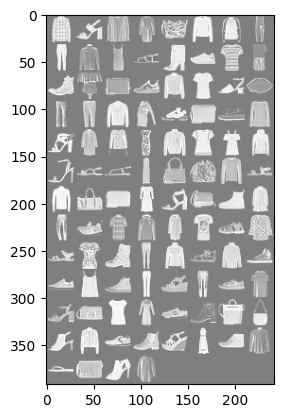

Shirt, Sandal, Shirt, Dress, Bag  


In [11]:
# Class names are not included, need to create them to plot the images.
# Creating a list of labels.
class_names = ['T-shirt/top', 'Trouser', 'Pullover',
               'Dress', 'Coat','Sandal', 'Shirt',
               'Sneaker', 'Bag', 'Ankle boot']


# The iterator to iterate images.
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images.
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Displaying images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(', '.join(f'{class_names[labels[j]]:5s}' for j in range(5)))

## Creating a Summary Writer instance

In [12]:
# Instantiate SummaryWriter:

# Creating an instance 't_board'.
t_board = SummaryWriter()
model = CNN()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
t_board.add_image('images', grid)
t_board.add_graph(model, images)
t_board.close()

## Training the CNN model

In [14]:
model = CNN()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
optimizer = opt.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Initialize the SummaryWriter object
t_board = SummaryWriter()

# Getting the number of correct labels after training.
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


# Notice:
'''argmax - gets the index corresponding to the highest value in a tensor.
  eq - compares the predicted labels to the True labels in the batch.
  sum - take the sum of the 1's to get total number of correct predictions.
  item - converts the one dimensional tensor to a floating point value.'''

for epoch in range(10):
    total_loss = 0
    total_correct = 0

    for images, labels in train_loader:
        images, labels = images, labels
        preds = model(images)

        loss = criterion(preds, labels)
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t_board.add_scalar('Loss', total_loss, epoch)
    t_board.add_scalar('Correct', total_correct, epoch)
    t_board.add_scalar('Accuracy', total_correct / len(train_set), epoch)

    t_board.add_histogram('conv1.bias', model.conv1.bias, epoch)
    t_board.add_histogram('conv1.weight', model.conv1.weight, epoch)
    t_board.add_histogram('conv2.bias', model.conv2.bias, epoch)
    t_board.add_histogram('conv2.weight', model.conv2.weight, epoch)


    print('Epoch:', epoch, '| total_correct:', total_correct, '| loss:', total_loss)

# Close the SummaryWriter object when finished.
t_board.close()

Epoch: 0 | total_correct: 44986 | loss: 392.5288498699665
Epoch: 1 | total_correct: 50472 | loss: 258.1482774466276
Epoch: 2 | total_correct: 51243 | loss: 236.03224427998066
Epoch: 3 | total_correct: 51802 | loss: 222.69941574335098
Epoch: 4 | total_correct: 51976 | loss: 217.35662904381752
Epoch: 5 | total_correct: 52133 | loss: 213.2691248357296
Epoch: 6 | total_correct: 52202 | loss: 209.56353729963303
Epoch: 7 | total_correct: 52306 | loss: 206.91521480679512
Epoch: 8 | total_correct: 52360 | loss: 203.5387341082096
Epoch: 9 | total_correct: 52428 | loss: 203.1063629090786


## Run Tensorboard

In [ ]:
# Command to run Tensorboard by the terminal on port 8000.
# tensorboard --logdir runs/ --port 8000

# Link to Tensorboard: http://localhost:8000/#timeseries